\begin{aligned}
\text{Maximise} \quad & f(x_1, x_2, x_3) = 3x_1 + 5x_2 + 2x_3 \\
\text{subject to} \quad 
& 2x_1 + 3x_2 + x_3 \leq 12 \\
& x_1 + 2x_2 + 2x_3 \leq 10 \\
& 3x_1 + x_2 + 2x_3 \leq 8 \\
& 0 \leq x_1, x_2, x_3 \leq 10 \\
& x_1, x_2, x_3 \in \mathbb{Z}
\end{aligned}

In [83]:
import pickle
with open('mlpResults.pkl', 'rb') as f:  
    mlpResults = pickle.load(f)  
with open('kanResults.pkl', 'rb') as f:  
    kanResults = pickle.load(f)  

mlpObjectives = mlpResults["mlpObjectives"]
mlpAllLosses = mlpResults["mlpAllLosses"]
mlpTimes = mlpResults["mlpTimes"]
mlpSummary = mlpResults["mlpSummary"]
mlpAllCoordinates = mlpResults["mlpAllCoordinates"]
mlpAllEuclideanAccuracies = mlpResults["mlpAllEuclideanAccuracies"]
mlpAllObjectiveAccuracies = mlpResults["mlpAllObjectiveAccuracies"]

kanObjectives = kanResults["kanObjectives"]
kanAllLosses = kanResults["kanAllLosses"]
kanTimes = kanResults["kanTimes"]
kanSummary = kanResults["kanSummary"]
kanAllCoordinates = kanResults["kanAllCoordinates"]
kanAllEuclideanAccuracies = kanResults["kanAllEuclideanAccuracies"]
kanAllObjectiveAccuracies = kanResults["kanAllObjectiveAccuracies"]


In [84]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import milp, LinearConstraint, Bounds, linprog
from kan import *
import time

In [2]:
c = np.array([-3, -5, -2])
A = np.array([
    [2, 3, 1],
    [1, 2, 2],
    [3, 1, 2]
])
b = np.array([12, 10, 8])
bounds = Bounds([0, 0, 0], [10, 10, 10])

result = linprog(c, A_ub=A, b_ub=b, bounds=[(0, None), (0, None), (0, None)], method="highs")
x_lp = result.x
obj_lp = -result.fun
print(f"Relaxed LP Solution: x = {x_lp.round(4)}, Objective = {obj_lp:.2f}")

#IP solution
integrality = np.array([1, 1, 1])
milpResult = milp(
    c=c,
    constraints=LinearConstraint(A, lb=-np.inf, ub=b),
    bounds=bounds,
    integrality=integrality
)

xAnalytical = list(map(int, milpResult.x))
objAnalytical = -milpResult.fun
print(f"Integer MILP Solution: x = {xAnalytical}, Objective = {objAnalytical:.2f}")

Relaxed LP Solution: x = [0.  3.5 1.5], Objective = 20.50
Integer MILP Solution: x = [1, 3, 1], Objective = 20.00


In [ ]:
#generating samples
A = np.array([
    [2.0, 3.0, 1.0],
    [1.0, 2.0, 2.0],
    [3.0, 1.0, 2.0]
])
b = np.array([12.0, 10.0, 8.0])

A_tensor = torch.tensor(A, dtype=torch.float32)
b_tensor = torch.tensor(b, dtype=torch.float32)

def objectiveFn(x):
    return 3 * x[:, 0] + 5 * x[:, 1] + 2 * x[:, 2]

def generateFeasibleSamples(n=10000):
    data, target = [], []
    for _ in range(n):
        x = torch.randint(0, 11, (3,), dtype=torch.float32)
        if torch.all(A_tensor @ x <= b_tensor):
            data.append(x)
            target.append(objectiveFn(x.unsqueeze(0)))
    return torch.stack(data), torch.stack(target)

In [32]:
#3 input nodes, 1 output
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(3, 32), nn.ReLU(),
            nn.Linear(32, 32), nn.ReLU(),
            nn.Linear(32, 1)
        )
    def forward(self, x):
        return self.model(x)

mlpNRuns = 5
mlpEpochs = 20000
mlpAllLosses = []
mlpSummary = []
mlpAllEuclideanAccuracies = []
mlpAllObjectiveAccuracies = []
mlpAllCoordinates = []

for run in range(mlpNRuns):
    # torch.manual_seed(run)
    # np.random.seed(run)

    xTrain, yTrain = generateFeasibleSamples(1000)
    yTrain = (yTrain - yTrain.mean()) / yTrain.std()

    mlpModel = MLP()
    optimiser = optim.AdamW(mlpModel.parameters(), lr=0.001)
    runLosses = []
    mlpRunEuclideanAccuracies = []
    mlpRunObjectiveAccuracies = []
    mlpRunCoordinates = []
    startTime = time.time()

    for epoch in range(mlpEpochs):
        mlpModel.train()
        optimiser.zero_grad()
        predictions = mlpModel(xTrain).squeeze()
        mseLoss = torch.mean((predictions - yTrain.squeeze())**2)
        loss = mseLoss - 0.1 * predictions.mean()
        loss.backward()
        optimiser.step()
        runLosses.append(loss.item())

        with torch.no_grad():
            mlpModel.eval()
            predictions = mlpModel(xTrain).squeeze()
            bestPrediction = torch.argmax(predictions)
            mlpBestX = xTrain[bestPrediction]
            # while not torch.all(A_tensor @ mlpBestX <= b_tensor):
            #     mlpBestX -= 0.1 * (A_tensor @ mlpBestX - b_tensor).clamp(min=0)
            #     mlpBestX = mlpBestX.round()
            mlpRunCoordinates.append(mlpBestX)
            mlpBestVal = objectiveFn(mlpBestX.unsqueeze(0)).item()
            mlpBestX1 = mlpBestX[0].item()
            mlpBestX2 = mlpBestX[1].item()
            mlpBestX3 = mlpBestX[2].item()
            euclideanDistance = torch.norm(torch.tensor([mlpBestX1, mlpBestX2, mlpBestX3]) - torch.tensor([xAnalytical[0], xAnalytical[1], xAnalytical[2]])).item()
            mlpRunEuclideanAccuracies.append(euclideanDistance)
            absoluteObjectiveDifference = abs(mlpBestVal - objAnalytical)
            mlpRunObjectiveAccuracies.append(absoluteObjectiveDifference)

    endTime = time.time()
    mlpAllLosses.append(runLosses)
    mlpAllCoordinates.append(mlpRunCoordinates)
    mlpAllEuclideanAccuracies.append(mlpRunEuclideanAccuracies)
    mlpAllObjectiveAccuracies.append(mlpRunObjectiveAccuracies)
    mlpSummary.append({
        "objective": mlpBestVal,
        "finalLoss": runLosses[-1],
        "time": endTime - startTime,
        "x1": mlpBestX1,
        "x2": mlpBestX2,
        "x3": mlpBestX3
    })

    print(f"Run {run+1}: Best x1 = {mlpBestX1:.2f}, x2 = {mlpBestX2:.2f}, x3 = {mlpBestX3:.2f} => Obj = {mlpBestVal:.2f}, Loss = {runLosses[-1]:.4f}")

mlpObjectives = [r["objective"] for r in mlpSummary]
mlpLosses = [r["finalLoss"] for r in mlpSummary]
mlpTimes = [r["time"] for r in mlpSummary]
mlpX1Vals = [r["x1"] for r in mlpSummary]
mlpX2Vals = [r["x2"] for r in mlpSummary]
mlpX3Vals = [r["x3"] for r in mlpSummary]

print(f"Mean Objective Value: {np.mean(mlpObjectives):.4f} +- {np.std(mlpObjectives):.4f}")
print(f"Mean Final Loss:      {np.mean(mlpLosses):.4f} +- {np.std(mlpLosses):.4f}")
print(f"Mean Time:            {np.mean(mlpTimes):.4f}s +- {np.std(mlpTimes):.4f}s")


Run 1: Best x1 = 1.00, x2 = 3.00, x3 = 1.00 => Obj = 20.00, Loss = -0.0025
Run 2: Best x1 = 0.00, x2 = 4.00, x3 = 0.00 => Obj = 20.00, Loss = -0.0024
Run 3: Best x1 = 0.00, x2 = 3.00, x3 = 2.00 => Obj = 19.00, Loss = -0.0025
Run 4: Best x1 = 0.00, x2 = 4.00, x3 = 0.00 => Obj = 20.00, Loss = -0.0025
Run 5: Best x1 = 1.00, x2 = 3.00, x3 = 1.00 => Obj = 20.00, Loss = -0.0025
Mean Objective Value: 19.8000 +- 0.4000
Mean Final Loss:      -0.0025 +- 0.0000
Mean Time:            60.6733s +- 4.6647s


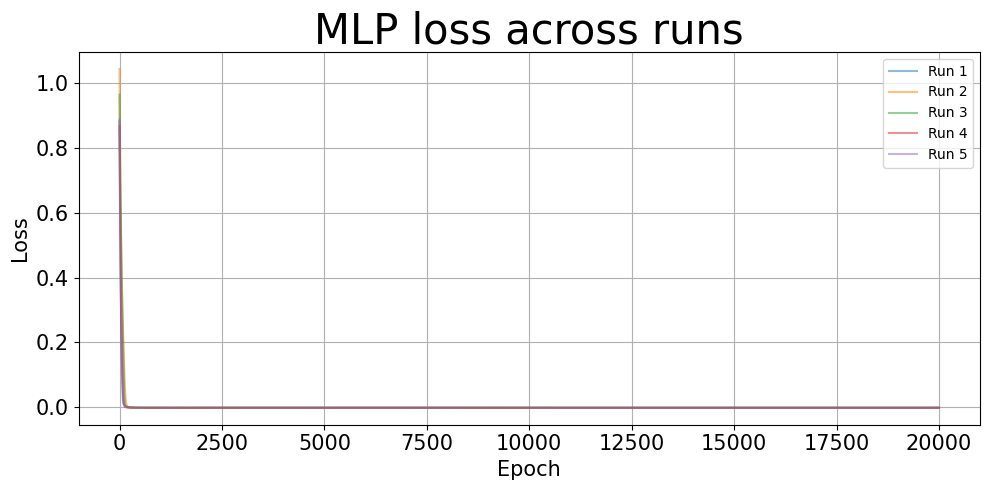

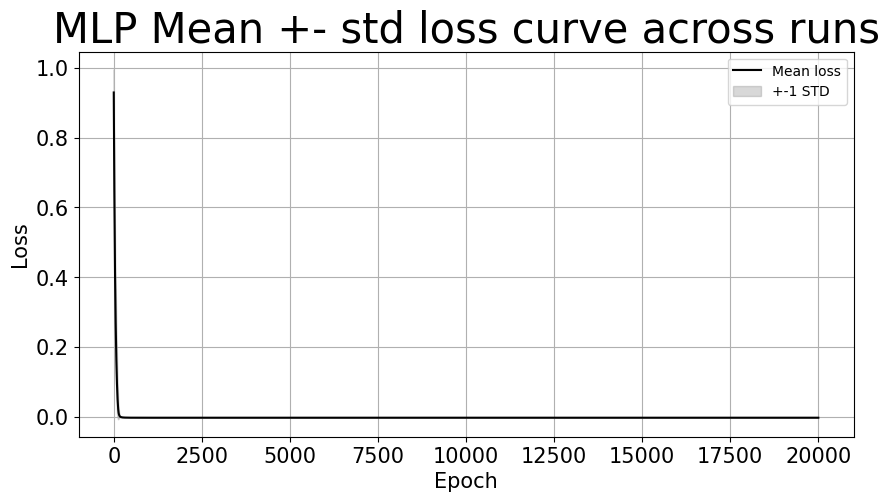

In [85]:
#loss graph
plt.figure(figsize=(10, 5))
for i, runLoss in enumerate(mlpAllLosses):
    plt.plot(runLoss, label=f"Run {i+1}", alpha=0.5)
plt.xlabel("Epoch", fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.yticks(fontsize=15)
plt.title("MLP loss across runs", fontsize=30)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

mlpLossArray = np.array(mlpAllLosses)
mlpMeanLoss = np.mean(mlpLossArray, axis=0)
mlpStdLoss = np.std(mlpLossArray, axis=0)

#mean and standard deviation of losses over all runs
plt.figure(figsize=(10, 5))
plt.plot(mlpMeanLoss, label="Mean loss", color='black')
plt.fill_between(range(20000), mlpMeanLoss - mlpStdLoss, mlpMeanLoss + mlpStdLoss,
                 color='gray', alpha=0.3, label="+-1 STD")
plt.xlabel("Epoch", fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.yticks(fontsize=15)
plt.title("MLP Mean +- std loss curve across runs", fontsize=30)
plt.grid(True)
plt.legend()
plt.show()

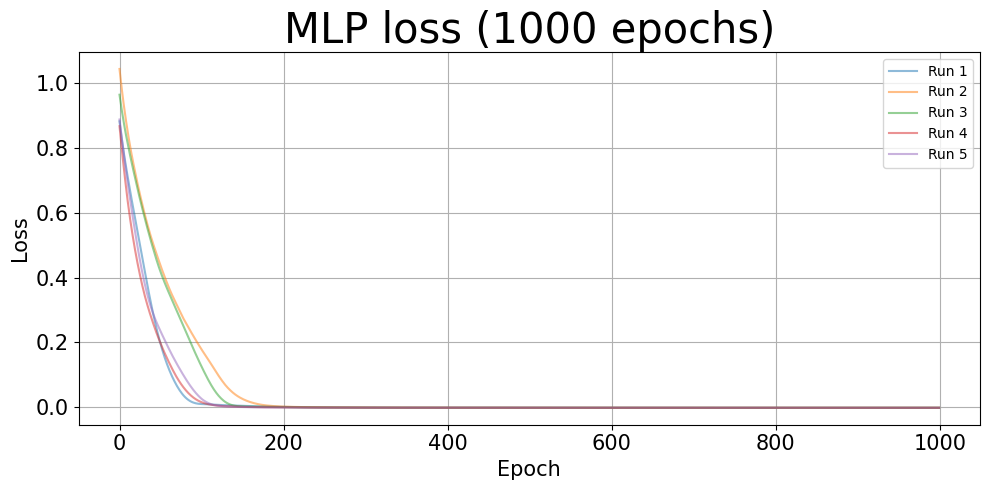

In [86]:
#loss graph restricted to 1000 epochs
plt.figure(figsize=(10, 5))
for i, runLoss in enumerate(mlpAllLosses):
    plt.plot(runLoss[:1000], label=f"Run {i+1}", alpha=0.5)
plt.xlabel("Epoch", fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.yticks(fontsize=15)
plt.title("MLP loss (1000 epochs)", fontsize=30)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

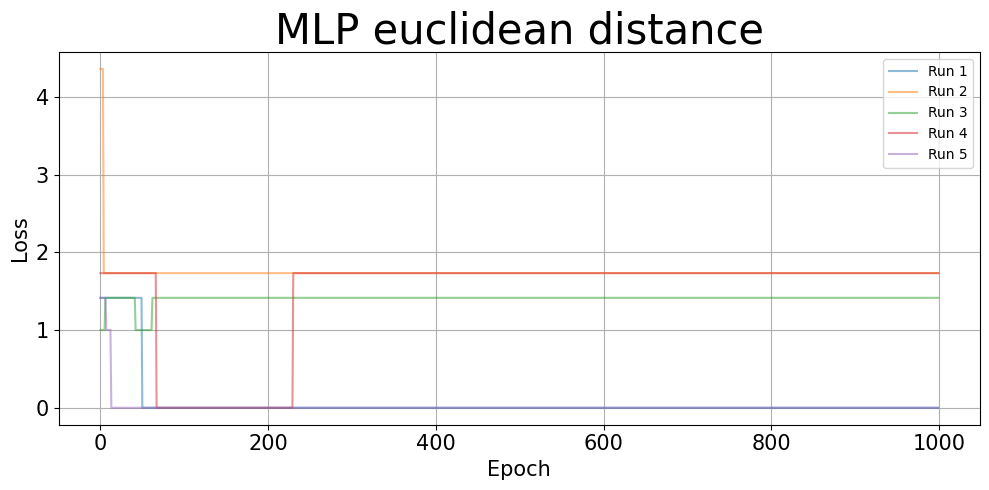

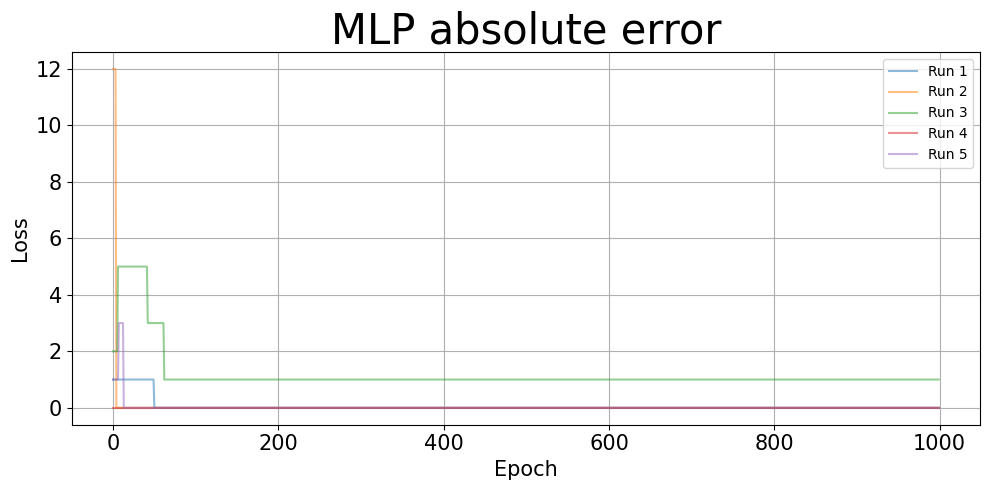

In [87]:
#euclidean distance over all runs
plt.figure(figsize=(10, 5))
for i, runAccuracy in enumerate(mlpAllEuclideanAccuracies):
    plt.plot(runAccuracy[:1000], label=f"Run {i+1}", alpha=0.5)
plt.xlabel("Epoch", fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.yticks(fontsize=15)
plt.title("MLP euclidean distance", fontsize=30)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#absolute error over all runs
plt.figure(figsize=(10, 5))
for i, runAccuracy in enumerate(mlpAllObjectiveAccuracies):
    plt.plot(runAccuracy[:1000], label=f"Run {i+1}", alpha=0.5)
plt.xlabel("Epoch", fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.yticks(fontsize=15)
plt.title("MLP absolute error", fontsize=30)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


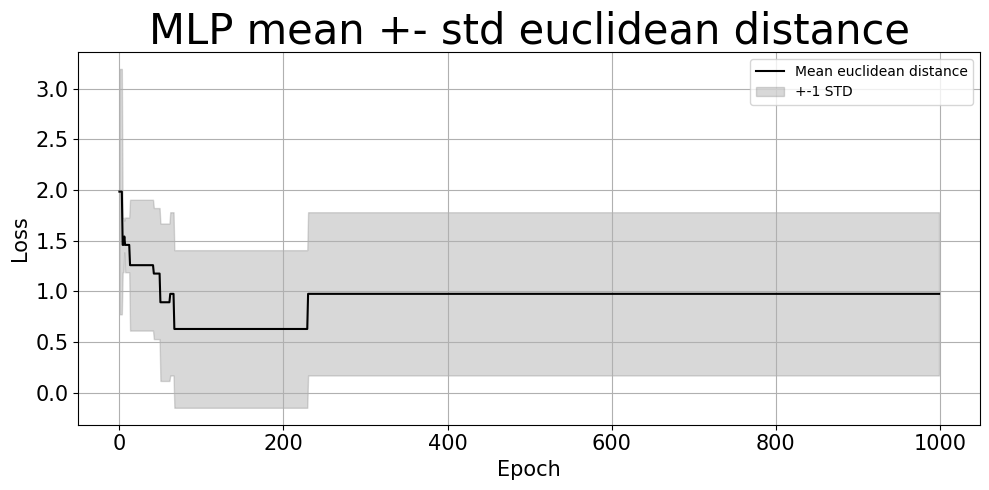

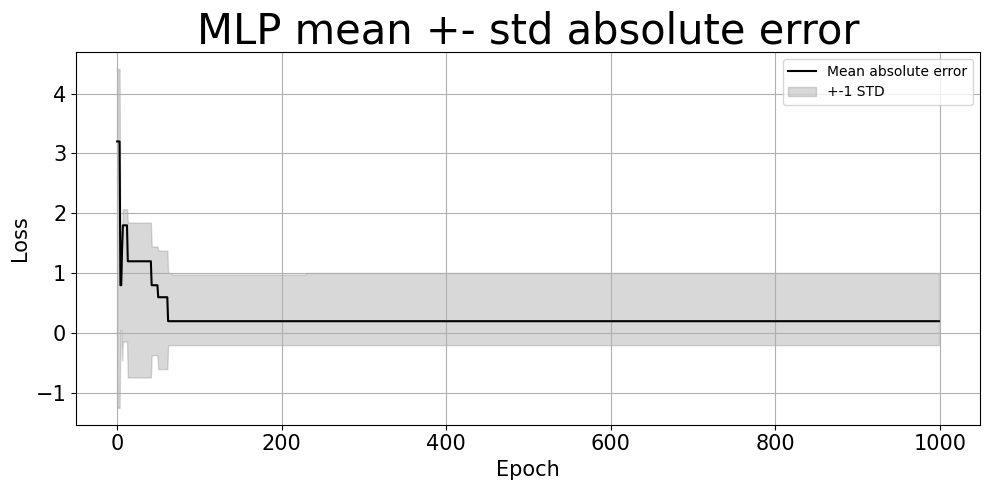

In [88]:
mlpEuclideanAccuracyArray = np.array(mlpAllEuclideanAccuracies)
mlpMeanEuclideanAccuracy = np.mean(mlpEuclideanAccuracyArray, axis=0)
mlpStdEuclideanAccuracy = np.std(mlpEuclideanAccuracyArray, axis=0)

#mean and std of euclidean distance
plt.figure(figsize=(10, 5))
plt.plot(mlpMeanEuclideanAccuracy[:1000], label="Mean euclidean distance", color='black')
plt.fill_between(range(1000), mlpMeanEuclideanAccuracy[:1000] - mlpStdEuclideanAccuracy[:1000], mlpMeanEuclideanAccuracy[:1000] + mlpStdEuclideanAccuracy[:1000],
                 color='gray', alpha=0.3, label="+-1 STD")
plt.xlabel("Epoch", fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.yticks(fontsize=15)
plt.title("MLP mean +- std euclidean distance", fontsize=30)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

mlpObjectiveAccuracyArray = np.array(mlpAllObjectiveAccuracies)
mlpMeanObjectiveAccuracy = np.mean(mlpObjectiveAccuracyArray, axis=0)
mlpStdObjectiveAccuracy = np.std(mlpObjectiveAccuracyArray, axis=0)

#mean and std of absolute error
plt.figure(figsize=(10, 5))
plt.plot(mlpMeanObjectiveAccuracy[:1000], label="Mean absolute error", color='black')
plt.fill_between(range(1000), mlpMeanObjectiveAccuracy[:1000] - mlpStdObjectiveAccuracy[:1000], mlpMeanObjectiveAccuracy[:1000] + mlpStdEuclideanAccuracy[:1000],
                 color='gray', alpha=0.3, label="+-1 STD")
plt.xlabel("Epoch", fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.yticks(fontsize=15)
plt.title("MLP mean +- std absolute error", fontsize=30)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [31]:
kanNRuns = 5
kanEpochs = 1000
kanAllLosses = []
kanSummary = []
kanAllEuclideanAccuracies = []
kanAllObjectiveAccuracies = []
kanAllCoordinates = []

for run in range(kanNRuns):
    # torch.manual_seed(run)
    # np.random.seed(run)

    xTrain, yTrain = generateFeasibleSamples(1000)
    yTrain = (yTrain - yTrain.mean()) / yTrain.std()

    kanModel = KAN(width=[3, 6, 6, 1], grid=5, k=3, seed=np.random.randint(0,99))
    startTime = time.time()
    

    optimiser = optim.AdamW(kanModel.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.StepLR(optimiser, step_size=500, gamma=0.5)

    runLosses = []
    kanRunEuclideanAccuracies = []
    kanRunObjectiveAccuracies = []
    kanRunCoordinates = []

    for epoch in range(kanEpochs):
        kanModel.train()
        optimiser.zero_grad()

        predictions = kanModel(xTrain).squeeze()
        mse = torch.mean((predictions - yTrain.squeeze())**2)
        loss = mse - 0.1 * predictions.mean() 
        loss.backward()
        optimiser.step()
        scheduler.step()

        runLosses.append(loss.item())

        with torch.no_grad():
            kanModel.eval()
            predictions = kanModel(xTrain).squeeze()
            bestPrediction = torch.argmax(predictions)
            kanBestX = xTrain[bestPrediction]
            kanRunCoordinates.append(kanBestX)
            bestVal = objectiveFn(kanBestX.unsqueeze(0)).item()
            kanBestXVals = kanBestX.cpu().numpy().astype(int)
            euclideanDistance = torch.norm(kanBestX - torch.tensor([xAnalytical[0], xAnalytical[1], xAnalytical[2]])).item()
            kanRunEuclideanAccuracies.append(euclideanDistance)
            absoluteObjectiveDifference = abs(bestVal - objAnalytical)
            kanRunObjectiveAccuracies.append(absoluteObjectiveDifference)

    endTime = time.time()
    kanAllLosses.append(runLosses)
    kanAllCoordinates.append(kanRunCoordinates)
    kanAllEuclideanAccuracies.append(kanRunEuclideanAccuracies)
    kanAllObjectiveAccuracies.append(kanRunObjectiveAccuracies)
    kanSummary.append({
        "objective": bestVal,
        "finalLoss": runLosses[-1],
        "time": endTime - startTime,
        "x1": kanBestXVals[0],
        "x2": kanBestXVals[1],
        "x3": kanBestXVals[2]
    })

    print(f"Run {run+1}: Best x1 = {kanBestXVals[0]}, x2 = {kanBestXVals[1]}, x3 = {kanBestXVals[2]} => Objective = {bestVal:.4f}, Loss = {runLosses[-1]:.4f}")

kanObjectives = [r["objective"] for r in kanSummary]
kanLosses = [r["finalLoss"] for r in kanSummary]
kanTimes = [r["time"] for r in kanSummary]
kanX1Vals = [r["x1"] for r in kanSummary]
kanX2Vals = [r["x2"] for r in kanSummary]
kanX3Vals = [r["x3"] for r in kanSummary]

kanLossArray = np.array(kanAllLosses)
kanMeanLoss = np.mean(kanLossArray, axis=0)
kanStdLoss = np.std(kanLossArray, axis=0)

print(f"Mean Objective Value: {np.mean(kanObjectives):.4f} +- {np.std(kanObjectives):.4f}")
print(f"Mean Final Loss:      {np.mean(kanLosses):.4f} +- {np.std(kanLosses):.4f}")
print(f"Mean Time:            {np.mean(kanTimes):.4f}s +- {np.std(kanTimes):.4f}s")

#kanModel
#kanObjectives
#kanLosses
#kanTimes
#kanX1Vals
#kanX2Vals
#kanX3Vals
#kanAllLosses
#kanMeanLoss
#kanStdLoss

checkpoint directory created: ./model
saving model version 0.0
Run 1: Best x1 = 1, x2 = 3, x3 = 1 => Objective = 20.0000, Loss = -0.0025
checkpoint directory created: ./model
saving model version 0.0
Run 2: Best x1 = 1, x2 = 3, x3 = 1 => Objective = 20.0000, Loss = -0.0025
checkpoint directory created: ./model
saving model version 0.0
Run 3: Best x1 = 0, x2 = 4, x3 = 0 => Objective = 20.0000, Loss = -0.0025
checkpoint directory created: ./model
saving model version 0.0
Run 4: Best x1 = 1, x2 = 3, x3 = 0 => Objective = 18.0000, Loss = -0.0025
checkpoint directory created: ./model
saving model version 0.0
Run 5: Best x1 = 0, x2 = 4, x3 = 0 => Objective = 20.0000, Loss = -0.0025
Mean Objective Value: 19.6000 +- 0.8000
Mean Final Loss:      -0.0025 +- 0.0000
Mean Time:            79.8887s +- 18.2624s


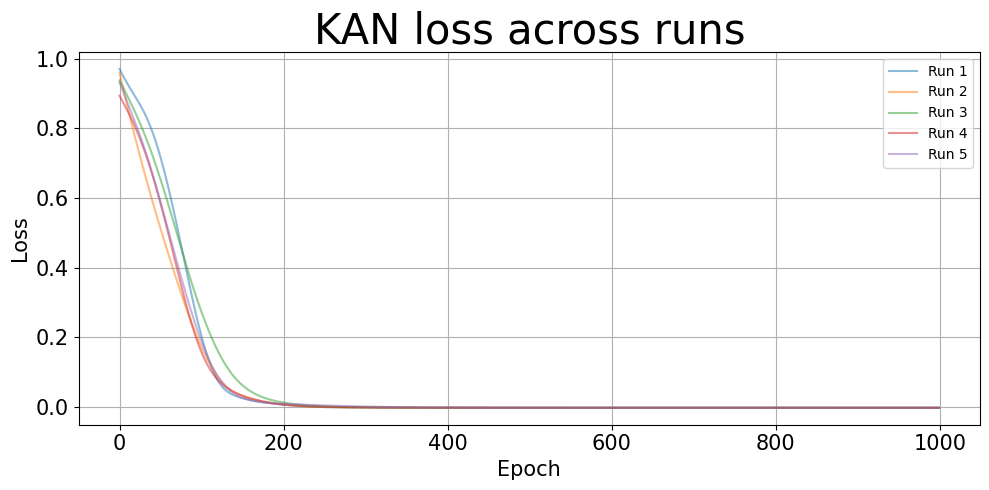

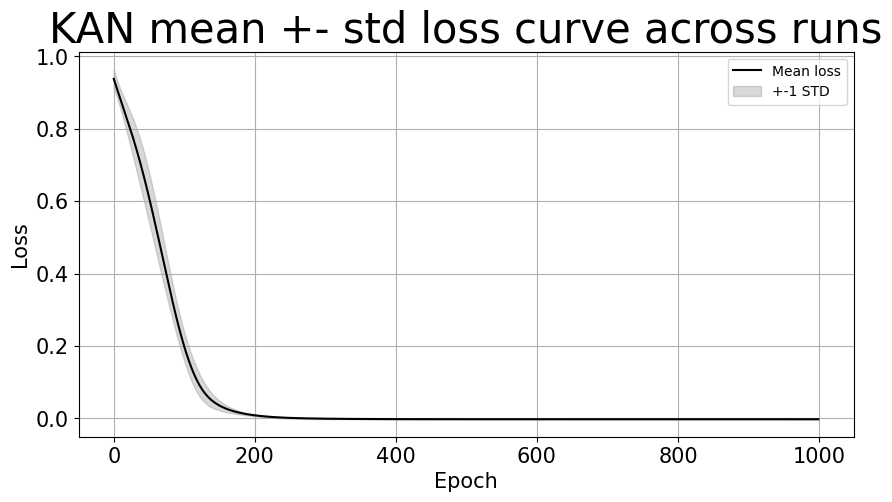

In [ ]:
#loss graph
plt.figure(figsize=(10, 5))
for i, runLoss in enumerate(kanAllLosses):
    plt.plot(runLoss, label=f"Run {i+1}", alpha=0.5)
plt.xlabel("Epoch", fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.yticks(fontsize=15)
plt.title("KAN loss across runs", fontsize=30)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#graph of mean +- std of loss
kanLossArray = np.array(kanAllLosses)
kanMeanLoss = np.mean(kanLossArray, axis=0)
kanStdLoss = np.std(kanLossArray, axis=0)

plt.figure(figsize=(10, 5))
plt.plot(kanMeanLoss, label="Mean loss", color='black')
plt.fill_between(range(1000), kanMeanLoss - kanStdLoss, kanMeanLoss + kanStdLoss,
                 color='gray', alpha=0.3, label="+-1 STD")
plt.xlabel("Epoch", fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.yticks(fontsize=15)
plt.title("KAN mean +- std loss curve across runs", fontsize=30)
plt.grid(True)
plt.legend()
plt.show()


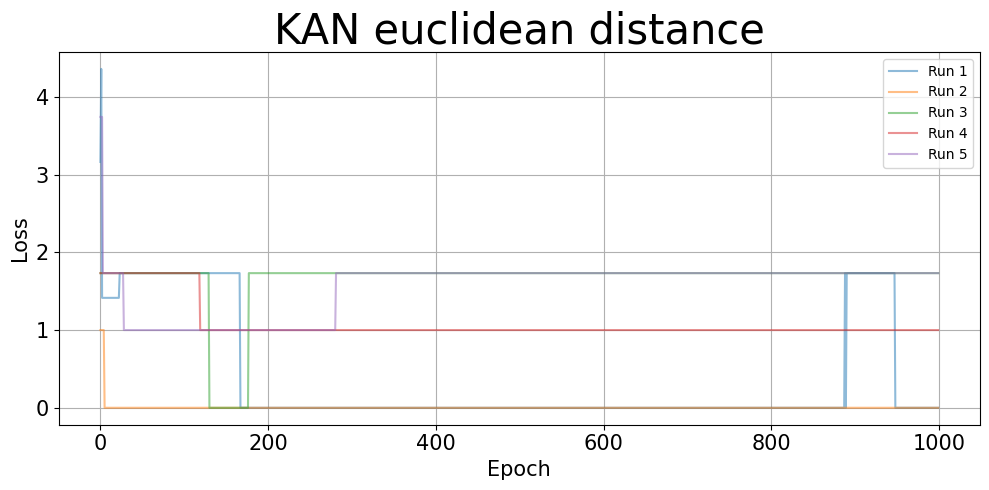

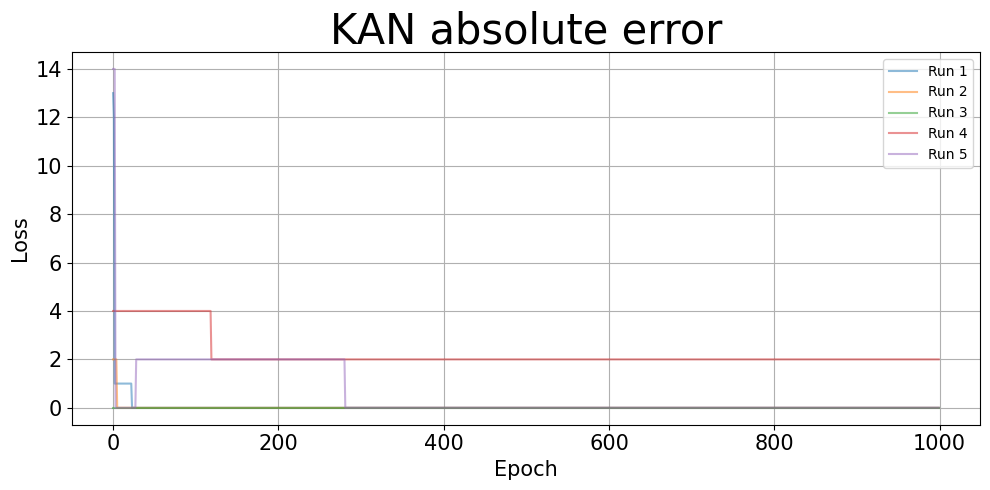

In [90]:
#kan euclidean distance across all runs
plt.figure(figsize=(10, 5))
for i, runAccuracy in enumerate(kanAllEuclideanAccuracies):
    plt.plot(runAccuracy, label=f"Run {i+1}", alpha=0.5)
plt.xlabel("Epoch", fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.yticks(fontsize=15)
plt.title("KAN euclidean distance", fontsize=30)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#kan absolute error across all runs
plt.figure(figsize=(10, 5))
for i, runAccuracy in enumerate(kanAllObjectiveAccuracies):
    plt.plot(runAccuracy, label=f"Run {i+1}", alpha=0.5)
plt.xlabel("Epoch", fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.yticks(fontsize=15)
plt.title("KAN absolute error", fontsize=30)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



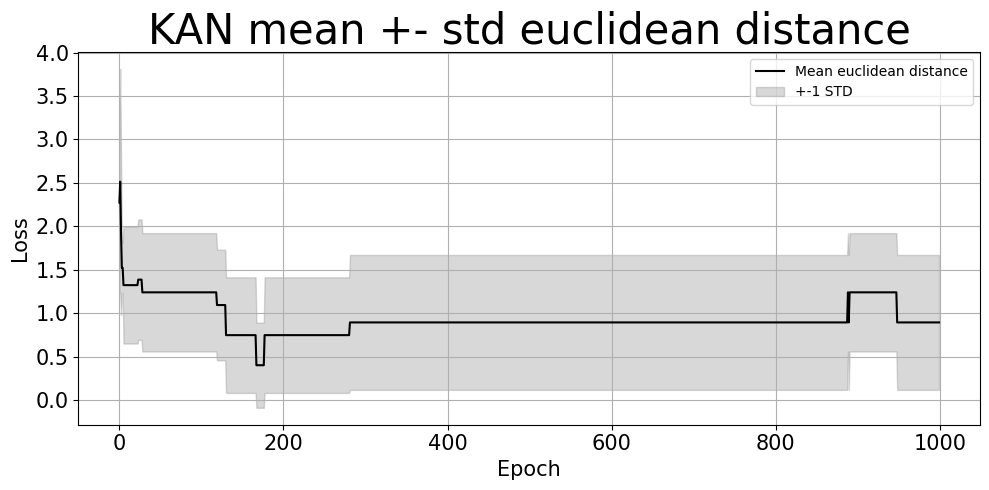

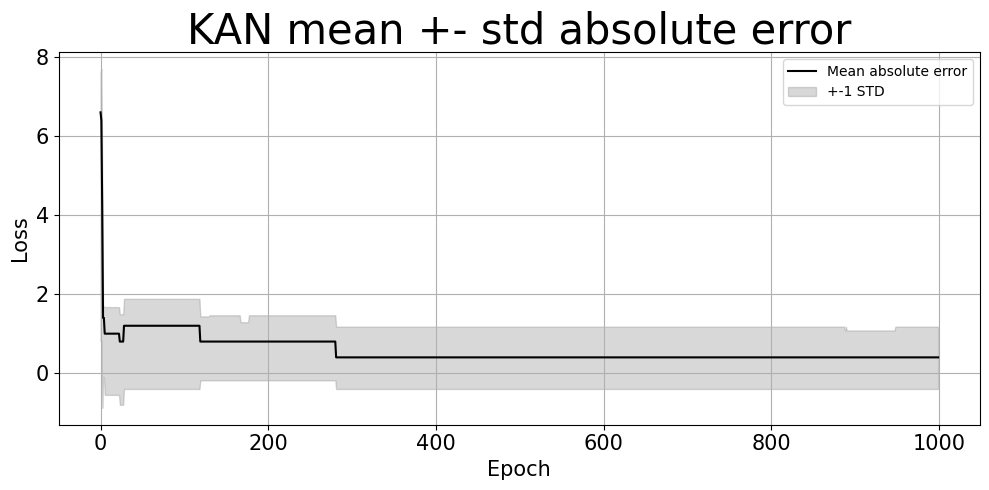

In [91]:
kanEuclideanAccuracyArray = np.array(kanAllEuclideanAccuracies)
kanMeanEuclideanAccuracy = np.mean(kanEuclideanAccuracyArray, axis=0)
kanStdEuclideanAccuracy = np.std(kanEuclideanAccuracyArray, axis=0)

#mean and std of euclidean distance
plt.figure(figsize=(10, 5))
plt.plot(kanMeanEuclideanAccuracy[:1000], label="Mean euclidean distance", color='black')
plt.fill_between(range(1000), kanMeanEuclideanAccuracy[:1000] - kanStdEuclideanAccuracy[:1000], kanMeanEuclideanAccuracy[:1000] + kanStdEuclideanAccuracy[:1000],
                 color='gray', alpha=0.3, label="+-1 STD")
plt.xlabel("Epoch", fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.yticks(fontsize=15)
plt.title("KAN mean +- std euclidean distance", fontsize=30)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

kanObjectiveAccuracyArray = np.array(kanAllObjectiveAccuracies)
kanMeanObjectiveAccuracy = np.mean(kanObjectiveAccuracyArray, axis=0)
kanStdObjectiveAccuracy = np.std(kanObjectiveAccuracyArray, axis=0)

#mean and std of absolute error
plt.figure(figsize=(10, 5))
plt.plot(kanMeanObjectiveAccuracy[:1000], label="Mean absolute error", color='black')
plt.fill_between(range(1000), kanMeanObjectiveAccuracy[:1000] - kanStdObjectiveAccuracy[:1000], kanMeanObjectiveAccuracy[:1000] + kanStdEuclideanAccuracy[:1000],
                 color='gray', alpha=0.3, label="+-1 STD")
plt.xlabel("Epoch", fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.yticks(fontsize=15)
plt.title("KAN mean +- std absolute error", fontsize=30)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

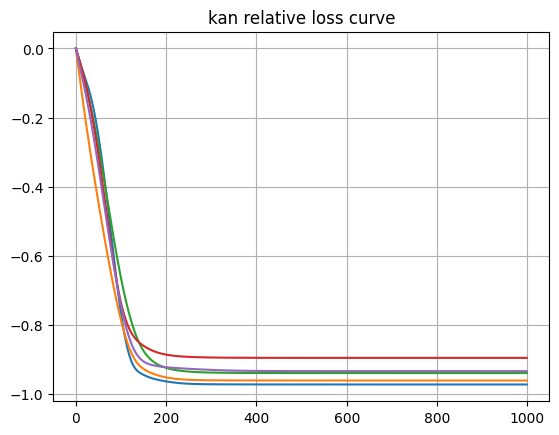

In [93]:
#curve to show relative loss from initial position.
#this is because the loss function results in losses that are very small, making it hard to visualise the raw values
for i, runLoss in enumerate(kanAllLosses):
    initialLoss = runLoss[0]
    relativeLoss = [l - initialLoss for l in runLoss]
    plt.plot(relativeLoss)
plt.title("kan relative loss curve")
plt.grid()
plt.show()

<b>Saving results to pickle files</b>  
If the values in the notebook are ever lost, I can just load the existing results instead of running everything again.  
with open('mlpResults.pkl', 'rb') as f:  
    mlpResults = pickle.load(f)  
with open('kanResults.pkl', 'rb') as f:  
    kanResults = pickle.load(f)  

In [42]:
import pickle

mlpResults = {
    "mlpObjectives": mlpObjectives,
    "mlpAllLosses": mlpAllLosses,
    "mlpTimes": mlpTimes,
    "mlpSummary": mlpSummary,
    "mlpAllCoordinates": mlpAllCoordinates,
    "mlpAllEuclideanAccuracies": mlpAllEuclideanAccuracies,
    "mlpAllObjectiveAccuracies": mlpAllObjectiveAccuracies
}

with open('mlpResults.pkl', 'wb') as f:
    pickle.dump(mlpResults, f)

kanResults = {
    "kanObjectives": kanObjectives,
    "kanAllLosses": kanAllLosses,
    "kanTimes": kanTimes,
    "kanSummary": kanSummary,
    "kanAllCoordinates": kanAllCoordinates,
    "kanAllEuclideanAccuracies": kanAllEuclideanAccuracies,
    "kanAllObjectiveAccuracies": kanAllObjectiveAccuracies
}

with open('kanResults.pkl', 'wb') as f:
    pickle.dump(kanResults, f)

In [70]:
#getting convergence speed
def computeConvergenceSpeed(allLosses, thresholdRatio=0.05):
    speeds = []
    for lossCurve in allLosses:
        finalLoss = lossCurve[-1]
        threshold = abs(finalLoss) * (1 + thresholdRatio)
        for i, loss in enumerate(lossCurve):
            if abs(loss) <= threshold:
                speeds.append(i)
                break
    return speeds
    
mlpConvergence = computeConvergenceSpeed(mlpAllLosses)
kanConvergence = computeConvergenceSpeed(kanAllLosses)

#model complexity - this is based on the parameter count for each
mlpParamCount = sum(p.numel() for p in mlpModel.parameters())
kanParamCount = sum(p.numel() for p in kanModel.parameters())

mlpBestObjective = np.max(mlpObjectives)
kanBestObjective = np.max(kanObjectives)



In [71]:
#metric comparison table
comparisonData = {
    "Metric": [
        "Mean Objective Value",
        "Std Objective Value",
        "Best Objective Value",
        "Mean Final Loss",
        "Std Final Loss",
        "Mean Time (s)",
        "Std Time (s)",
        "Mean Convergence Epoch",
        "Std Convergence Epoch",
        "Model Parameters"
    ],
    "MLP": [
        np.mean(mlpObjectives),
        np.std(mlpObjectives),
        mlpBestObjective,
        np.mean(mlpLosses),
        np.std(mlpLosses),
        np.mean(mlpTimes),
        np.std(mlpTimes),
        np.mean(mlpConvergence),
        np.std(mlpConvergence),
        mlpParamCount
    ],
    "KAN": [
        np.mean(kanObjectives),
        np.std(kanObjectives),
        kanBestObjective,
        np.mean(kanLosses),
        np.std(kanLosses),
        np.mean(kanTimes),
        np.std(kanTimes),
        np.mean(kanConvergence),
        np.std(kanConvergence),
        kanParamCount
    ]
}

comparisonDf = pd.DataFrame(comparisonData)
display(comparisonDf)


,Metric,MLP,KAN
0,Mean Objective Value,19.800000,1.960000e+01
1,Std Objective Value,0.400000,8.000000e-01
2,Best Objective Value,20.000000,2.000000e+01
3,Mean Final Loss,-0.002476,-2.499027e-03
4,Std Final Loss,0.000039,6.367693e-07
5,Mean Time (s),60.673300,7.988872e+01
6,Std Time (s),4.664675,1.826244e+01
7,Mean Convergence Epoch,149.600000,2.368000e+02
8,Std Convergence Epoch,23.938254,2.082691e+01
9,Model Parameters,1217.000000,1.192000e+03


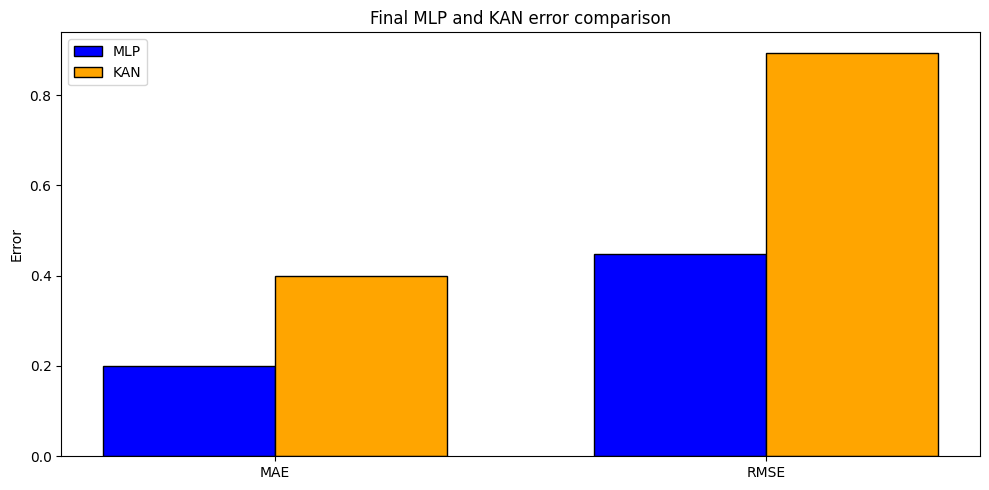

In [94]:
mlpMeanAbsError = abs(np.mean(mlpObjectives) - objAnalytical)
kanMeanAbsError = abs(np.mean(kanObjectives) - objAnalytical)
mlpRMSE = np.sqrt(np.mean((np.array(mlpObjectives) - objAnalytical)**2))
kanRMSE = np.sqrt(np.mean((np.array(kanObjectives) - objAnalytical)**2))

metrics = ['MAE', 'RMSE']
mlpErrors = [mlpMeanAbsError, mlpRMSE]
kanErrors = [kanMeanAbsError, kanRMSE]

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(10, 5))
plt.bar(x - width/2, mlpErrors, width, label='MLP', color='blue', edgecolor='black')
plt.bar(x + width/2, kanErrors, width, label='KAN', color='orange', edgecolor='black')

plt.ylabel('Error')
plt.title('Final MLP and KAN error comparison')
plt.xticks(x, metrics)
plt.legend()
plt.tight_layout()
plt.show()


C:\Users\A\AppData\Local\Temp\ipykernel_15056\2367243651.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


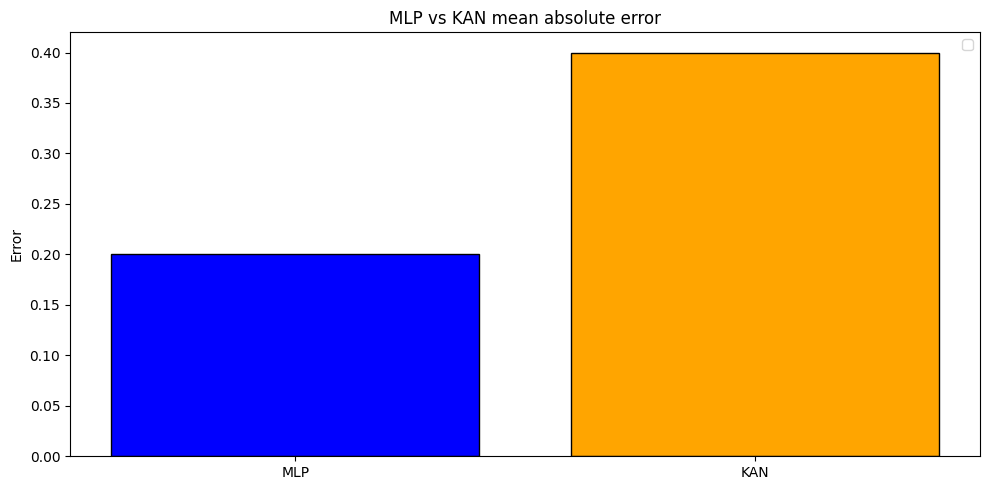

In [95]:
plt.figure(figsize=(10, 5))
plt.bar("MLP", mlpMeanAbsError, color='blue', edgecolor='black')
plt.bar("KAN", kanMeanAbsError, color='orange', edgecolor='black')
plt.ylabel('Error')
plt.title("MLP vs KAN mean absolute error")
plt.legend()
plt.tight_layout()
plt.show()


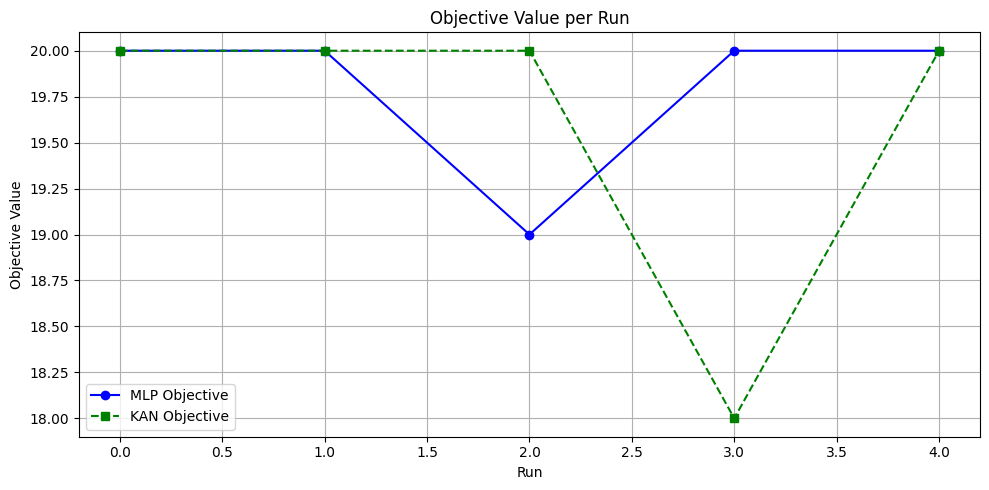

In [72]:
#objective value across models
plt.figure(figsize=(10, 5))
plt.plot(mlpObjectives, 'o-', label="MLP Objective", color='blue')
plt.plot(kanObjectives, 's--', label="KAN Objective", color='green')
plt.title("Objective Value per Run")
plt.xlabel("Run")
plt.ylabel("Objective Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

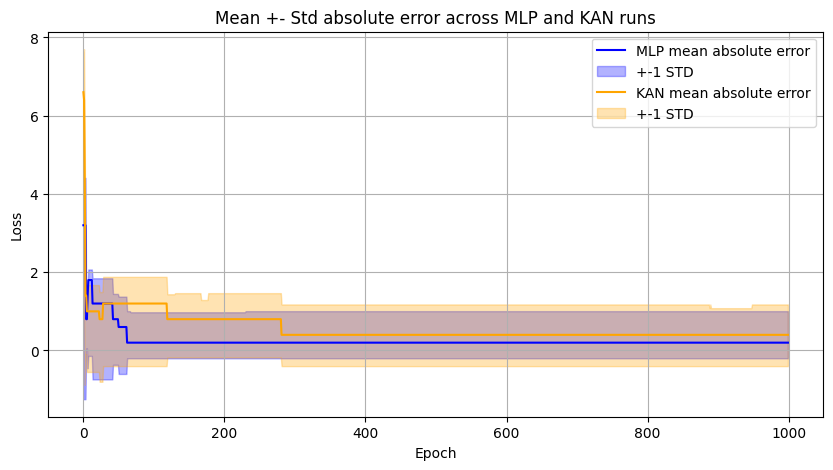

In [97]:
#absolute error comparison
start = 0
epochLimit = 1000
epochs = np.arange(start, epochLimit)
plt.figure(figsize=(10, 5))
plt.plot(epochs, mlpMeanObjectiveAccuracy[start:epochLimit], label="MLP mean absolute error", color='blue')
plt.fill_between(epochs, mlpMeanObjectiveAccuracy[start:epochLimit] - mlpStdObjectiveAccuracy[start:epochLimit], mlpMeanObjectiveAccuracy[start:epochLimit] + mlpStdEuclideanAccuracy[start:epochLimit],
                 color='blue', alpha=0.3, label="+-1 STD")
plt.plot(epochs, kanMeanObjectiveAccuracy[start:epochLimit], label="KAN mean absolute error", color='orange')
plt.fill_between(epochs, kanMeanObjectiveAccuracy[start:epochLimit] - kanStdObjectiveAccuracy[start:epochLimit], kanMeanObjectiveAccuracy[start:epochLimit] + kanStdEuclideanAccuracy[start:epochLimit],
                 color='orange', alpha=0.3, label="+-1 STD")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Mean +- Std absolute error across MLP and KAN runs")
plt.grid(True)
plt.legend()
plt.show()

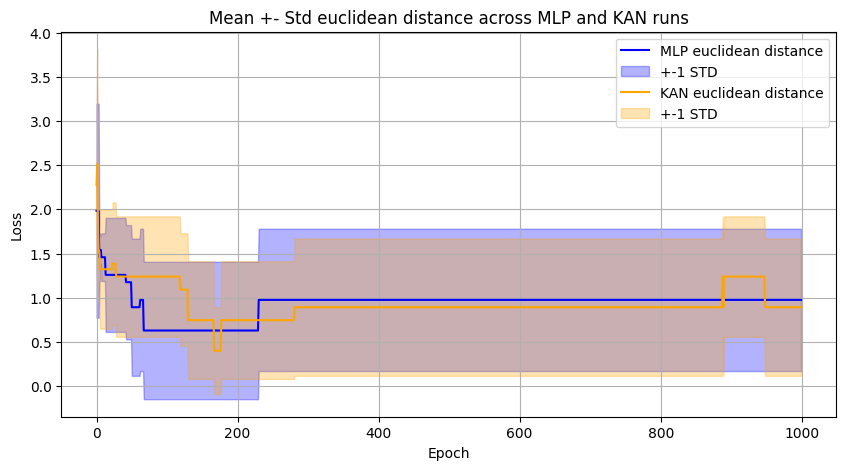

In [98]:
#euclidean distance comparison
start = 0
epochLimit = 1000
epochs = np.arange(start, epochLimit)
plt.figure(figsize=(10, 5))
plt.plot(epochs, mlpMeanEuclideanAccuracy[start:epochLimit], label="MLP euclidean distance", color='blue')
plt.fill_between(epochs, mlpMeanEuclideanAccuracy[start:epochLimit] - mlpStdEuclideanAccuracy[start:epochLimit], mlpMeanEuclideanAccuracy[start:epochLimit] + mlpStdEuclideanAccuracy[start:epochLimit],
                 color='blue', alpha=0.3, label="+-1 STD")
plt.plot(epochs, kanMeanEuclideanAccuracy[start:epochLimit], label="KAN euclidean distance", color='orange')
plt.fill_between(epochs, kanMeanEuclideanAccuracy[start:epochLimit] - kanStdEuclideanAccuracy[start:epochLimit], kanMeanEuclideanAccuracy[start:epochLimit] + kanStdEuclideanAccuracy[start:epochLimit],
                 color='orange', alpha=0.3, label="+-1 STD")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Mean +- Std euclidean distance across MLP and KAN runs")
plt.grid(True)
plt.legend()
plt.show()

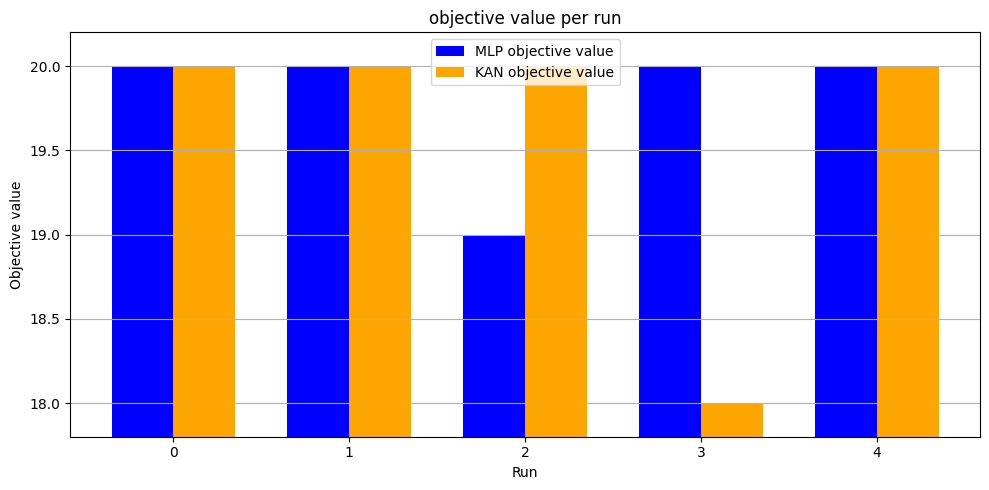

In [99]:
#bar graph of objective values in each run
runs = np.arange(len(mlpObjectives))
bar_width = 0.35
offset = bar_width / 2
plt.figure(figsize=(10, 5))
plt.bar(runs - offset, mlpObjectives, width=bar_width, label="MLP objective value", color='blue')
plt.bar(runs + offset, kanObjectives, width=bar_width, label="KAN objective value", color='orange')

plt.title("objective value per run")
plt.xlabel("Run")
plt.ylabel("Objective value")
plt.xticks(runs)
plt.legend()
plt.grid(True, axis='y')
minVal = min(min(mlpObjectives), min(kanObjectives))
maxVal = max(max(mlpObjectives), max(kanObjectives))
padding = (maxVal - minVal) * 0.1
plt.ylim(minVal - padding, maxVal + padding)
plt.tight_layout()
plt.show()

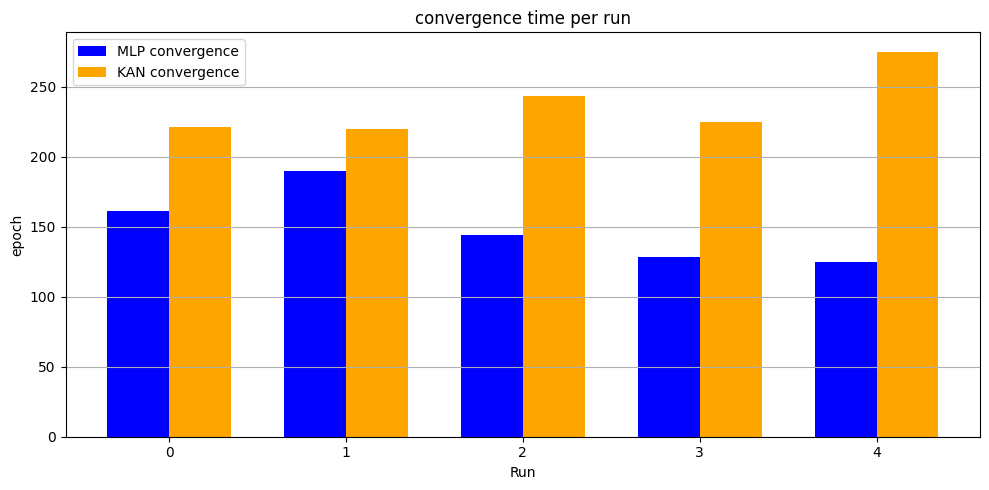

In [76]:
#convergence time comparison
runs = np.arange(len(mlpObjectives))
bar_width = 0.35
offset = bar_width / 2
plt.figure(figsize=(10, 5))
plt.bar(runs - offset, mlpConvergence, width=bar_width, label="MLP convergence", color='blue')
plt.bar(runs + offset, kanConvergence, width=bar_width, label="KAN convergence", color='orange')

plt.title("convergence time per run")
plt.xlabel("Run")
plt.ylabel("epoch")
plt.xticks(runs)
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

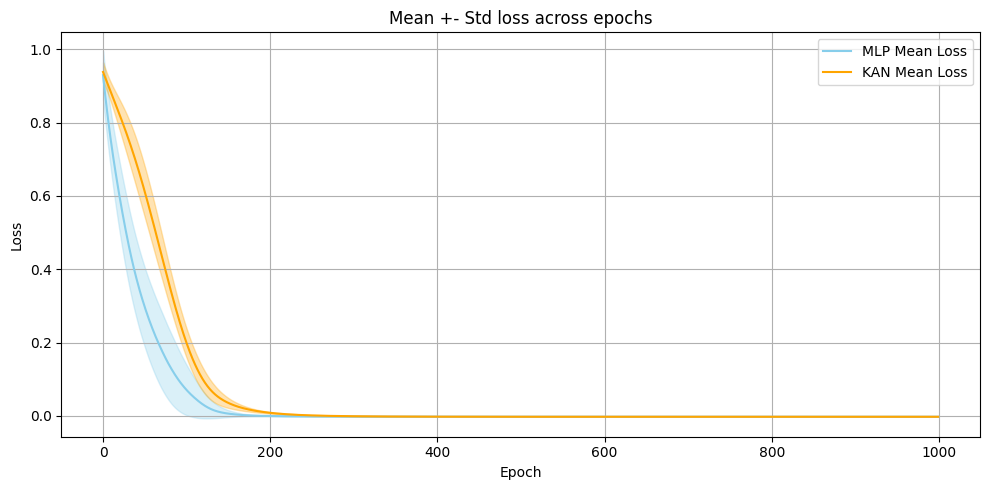

In [100]:
#loss comparison
mlpLossArray = np.array(mlpAllLosses)
kanLossArray = np.array(kanAllLosses)

mlpMeanLoss = np.mean(mlpLossArray, axis=0)[:1000]
mlpStdLoss = np.std(mlpLossArray, axis=0)[:1000]

kanMeanLoss = np.mean(kanLossArray, axis=0)
kanStdLoss = np.std(kanLossArray, axis=0)

plt.figure(figsize=(10, 5))
plt.plot(mlpMeanLoss, label="MLP Mean Loss", color='skyblue')
plt.fill_between(range(len(mlpMeanLoss)),
                 mlpMeanLoss - mlpStdLoss,
                 mlpMeanLoss + mlpStdLoss,
                 alpha=0.3, color='skyblue')

plt.plot(kanMeanLoss, label="KAN Mean Loss", color='orange')
plt.fill_between(range(len(kanMeanLoss)),
                 kanMeanLoss - kanStdLoss,
                 kanMeanLoss + kanStdLoss,
                 alpha=0.3, color='orange')

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Mean +- Std loss across epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


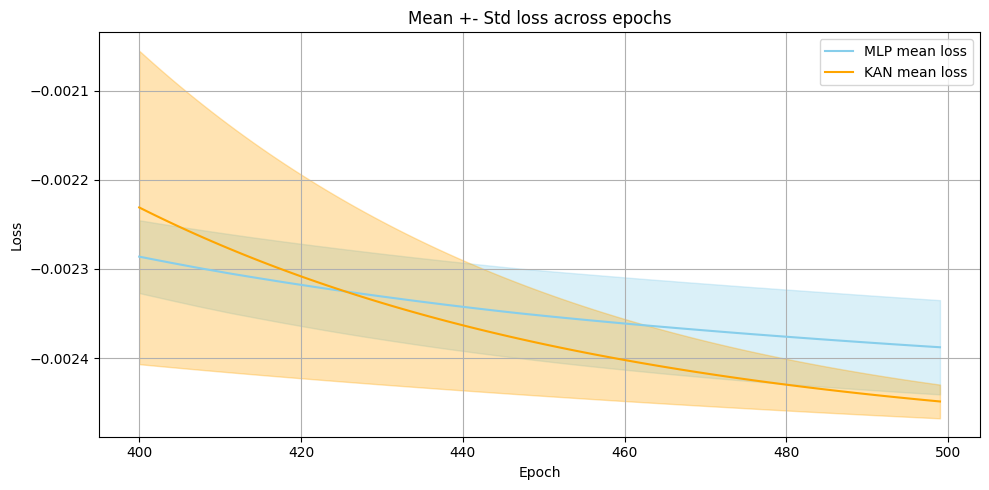

In [110]:
start = 400
end = 500
epochs = np.arange(start, end)

mlpLossArray = np.array(mlpAllLosses)
kanLossArray = np.array(kanAllLosses)
mlpMeanLoss = np.mean(mlpLossArray, axis=0)[start:end]
mlpStdLoss = np.std(mlpLossArray, axis=0)[start:end]
kanMeanLoss = np.mean(kanLossArray, axis=0)[start:end]
kanStdLoss = np.std(kanLossArray, axis=0)[start:end]


plt.figure(figsize=(10, 5))
plt.plot(epochs, mlpMeanLoss, label="MLP mean loss", color='skyblue')
plt.fill_between(epochs,
                 mlpMeanLoss - mlpStdLoss,
                 mlpMeanLoss + mlpStdLoss,
                 alpha=0.3, color='skyblue')

plt.plot(epochs, kanMeanLoss, label="KAN mean loss", color='orange')
plt.fill_between(epochs,
                 kanMeanLoss - kanStdLoss,
                 kanMeanLoss + kanStdLoss,
                 alpha=0.3, color='orange')

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Mean +- Std loss across epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [78]:
mlpBestPrediction = np.argmax(mlpObjectives)
kanBestPrediction = np.argmax(kanObjectives)

mlpBestX1 = mlpX1Vals[mlpBestPrediction]
mlpBestX2 = mlpX2Vals[mlpBestPrediction]
mlpBestX3 = mlpX3Vals[mlpBestPrediction]
kanBestX1 = kanX1Vals[kanBestPrediction]
kanBestX2 = kanX2Vals[kanBestPrediction]
kanBestX3 = kanX3Vals[kanBestPrediction]

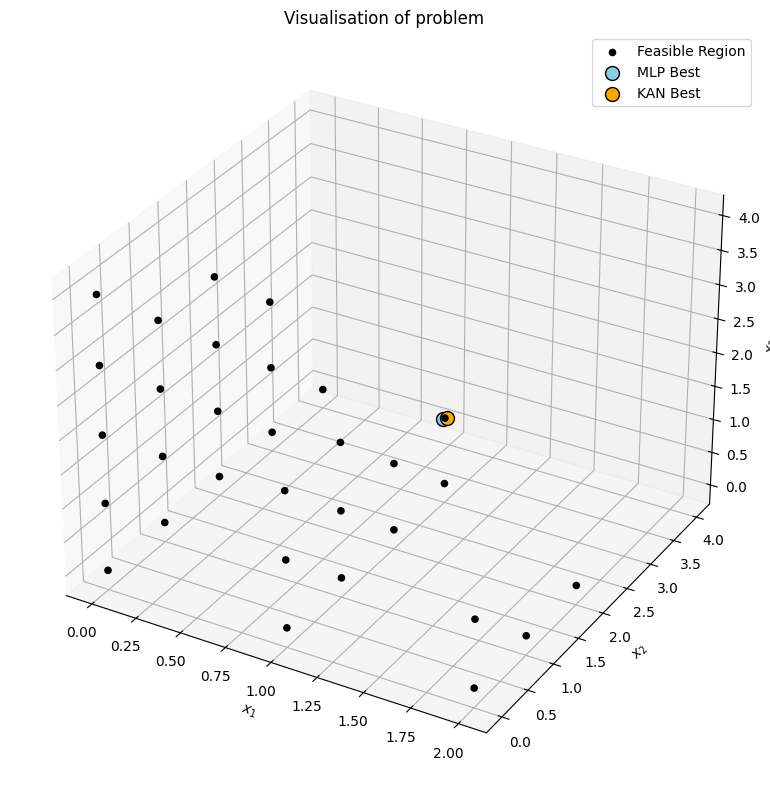

In [82]:
A = np.array([[2, 3, 1],
              [1, 2, 2],
              [3, 1, 2]])
b = np.array([12, 10, 8])

x1Vals = np.arange(0, 11)
x2Vals = np.arange(0, 11)
x3Vals = np.arange(0, 11)
feasible_points = []
for x1 in x1Vals:
    for x2 in x2Vals:
        for x3 in x3Vals:
            x = np.array([x1, x2, x3])
            if np.all(A @ x <= b):
                feasible_points.append(x)

feasible_points = np.array(feasible_points)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(feasible_points[:, 0], feasible_points[:, 1], feasible_points[:, 2],
           color='black', s=20, alpha=1, label='Feasible Region')
mlpBestX = np.array([mlpBestX1, mlpBestX2, mlpBestX3])
kanBestX = np.array([kanBestX1, kanBestX2, kanBestX3])
offset = 0.01
ax.scatter(*mlpBestX-offset, color='skyblue', s=100, edgecolor='black', label='MLP Best')
ax.scatter(*kanBestX+offset, color='orange', s=100, edgecolor='black', label='KAN Best')

ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$x_3$')
ax.set_title('Visualisation of problem')
ax.legend()
plt.tight_layout()
plt.show()
